In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2026-02-02 17:42:54.790769: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-02 17:42:54.840394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 17:42:56.383397: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
print(tf.__version__)

2.20.0


In [3]:
batch_size = 32
img_height = 128
img_width = 128

directory = os.path.join(os.getcwd(),"data", "training")

In [4]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15244 files belonging to 9 classes.
Using 12196 files for training.


2026-02-02 17:42:57.833544: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 15244 files belonging to 9 classes.
Using 3048 files for validation.


In [5]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# cache(): Keeps images in memory after the first epoch (speeds up disk I/O)
# shuffle(): Re-shuffles the training data every epoch
# prefetch(): Prepares the next batch while the model is training on the current one
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


2026-02-02 17:43:00.366765: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


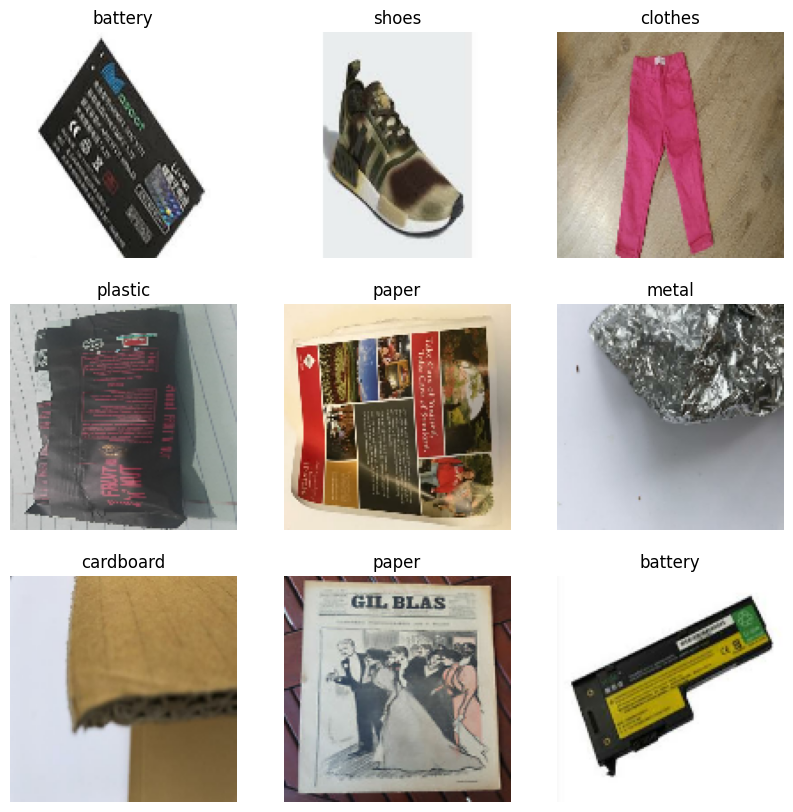

In [7]:
plt.figure(figsize=(10,10))

for images, labels in training_ds.take(1): #takes one batch of 32
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

In [8]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

/home/cemil/NodeProjects/Sorti/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2026-02-02 17:43:01.150167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


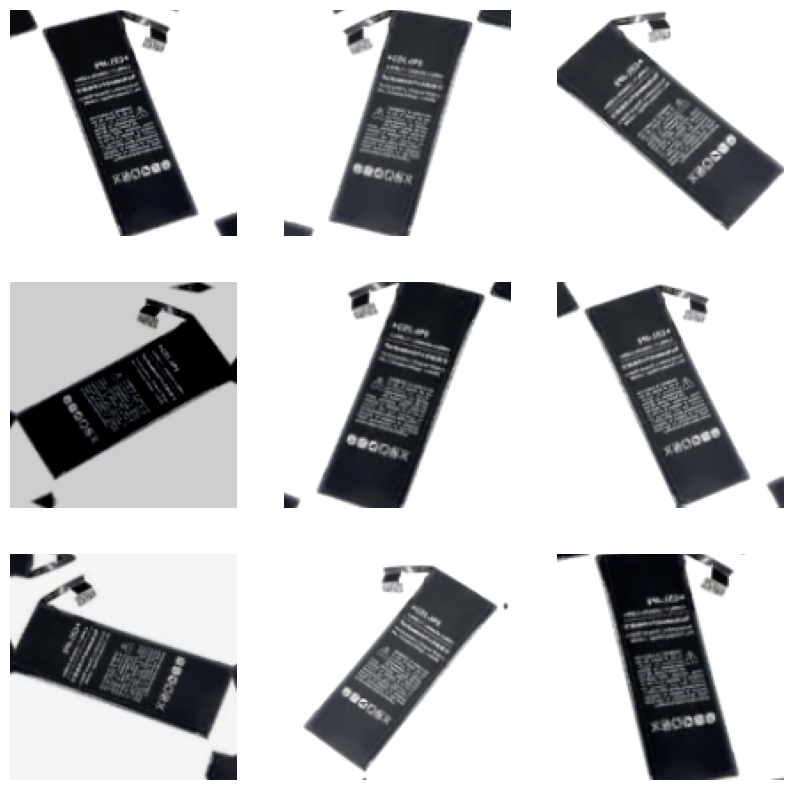

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [10]:
# Run 1 simple CNN 

num_classes = len(class_names)

model = tf.keras.Sequential([

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,025 (8.09 MB)

 Trainable params: 2,122,025 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 20

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.4372 - loss: 1.5694 - val_accuracy: 0.5492 - val_loss: 1.2698
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.6289 - loss: 1.0806 - val_accuracy: 0.6345 - val_loss: 1.0929
Epoch 3/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.7190 - loss: 0.8159 - val_accuracy: 0.6391 - val_loss: 1.1426
Epoch 4/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.7962 - loss: 0.6021 - val_accuracy: 0.7090 - val_loss: 0.9393
Epoch 5/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.8595 - loss: 0.4132 - val_accuracy: 0.7359 - val_loss: 0.9602
Epoch 6/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.9179 - loss: 0.2583 - val_accuracy: 0.7306 - val_loss: 1.0460
Epoch 7/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.9444 - loss: 0.1769 - val_accuracy: 0.7208 - val_loss: 1.2536
Epoch 8/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 39s 101ms/step - accuracy: 0.9679 - loss: 0

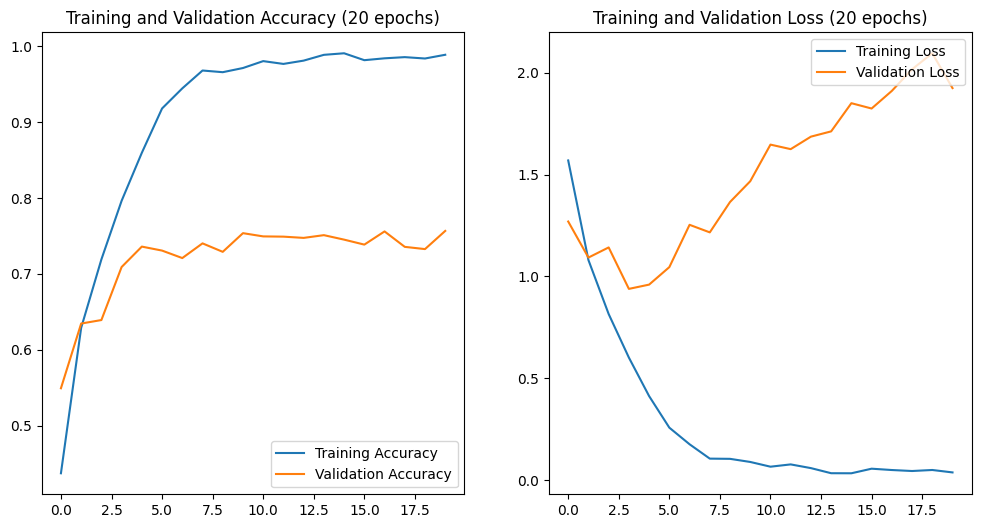

In [12]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [13]:
#Run 2 add data augmentation

num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,025 (8.09 MB)

 Trainable params: 2,122,025 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 20

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.3929 - loss: 1.6799 - val_accuracy: 0.4997 - val_loss: 1.4048
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.5141 - loss: 1.3782 - val_accuracy: 0.4993 - val_loss: 1.3943
Epoch 3/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.5658 - loss: 1.2480 - val_accuracy: 0.5912 - val_loss: 1.2186
Epoch 4/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.6005 - loss: 1.1536 - val_accuracy: 0.5827 - val_loss: 1.2949
Epoch 5/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.6306 - loss: 1.0669 - val_accuracy: 0.6155 - val_loss: 1.1609
Epoch 6/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.6479 - loss: 1.0156 - val_accuracy: 0.6122 - val_loss: 1.1839
Epoch 7/20
278/382 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.6739 - loss: 0.9609

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot4(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#Run 3 add dropout to fight overfitting 

num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 20

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot4(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#run 4 (bigger model, added batchnormalization and more layers, increased epochs to 100 and callbacks and regularization)

#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    # Dense Block (The Classifier)
    # Note: We stick to 1-2 dense layers for CNNs to avoid parameter explosion
    tf.keras.layers.Dense(512, use_bias=False, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

In [ ]:
model_filename = 'run_6.keras'

In [ ]:
model.save(model_filename)

In [ ]:
#CREATING CONFUSION MATRIX

import numpy as np

loaded_model = tf.keras.models.load_model(model_filename)

y_true = []
y_pred = []

for images, labels in validation_ds:
    predictions = loaded_model.predict(images, verbose=0)

    #argmax to pick index of highest number
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot it as a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix: Where is the model confused?')
plt.ylabel('True Label (Truth)')
plt.xlabel('Predicted Label (Model Guess)')
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit